## Breast Cancer Proteomes
### Dividing cancer patients into separate sub-classes

The data was acquired to assess how the mutations in the DNA are affecting the protein expression landscape in breast cancer. Genes in our DNA are first transcribed into RNA molecules which then are translated into proteins. Changing the information content of DNA has impact on the behavior of the proteome, which is the main functional unit of cells, taking care of cell division, DNA repair, enzymatic reactions and signaling etc. They original study performed K-means clustering on the protein data to divide the breast cancer patients into sub-types, each having unique protein expression signature. They found that the best clustering was achieved using 3 clusters (original PAM50 gene set yields four different subtypes using RNA data). I'll run various dimensionality reduction techniques and clustering methods and compare my results with the original study.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sklearn.manifold import TSNE
import umap

In [2]:
# Load data
expression = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\77_cancer_proteomes_CPTAC_itraq.csv', header = 0, index_col = 0)
clinical = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\clinical_data_breast_cancer.csv', header = 0, index_col = 0)
proteins = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\PAM50_proteins.csv', header = 0, index_col = 0)

## Data Exploration: Protein Expression Data

In [3]:
expression.head()

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [4]:
expression.describe()

,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
count,11334.000000,11335.000000,11334.000000,12024.000000,12025.000000,11833.000000,11833.000000,11732.000000,11732.000000,11276.000000,...,11477.000000,10324.000000,10324.000000,10324.000000,9694.000000,9693.000000,9697.000000,10912.000000,10885.000000,10913.000000
mean,0.133079,0.128822,-0.440764,-0.729233,-0.039436,0.115353,-0.618354,-0.305320,-0.021228,0.077247,...,-0.677085,-0.103215,-0.021222,-0.100912,0.488502,-0.368762,-0.050669,0.069555,-0.298170,0.310974
std,1.734231,1.579845,1.634930,2.422452,1.353505,1.652918,2.281818,1.567687,1.651917,1.749695,...,2.018394,1.570606,1.656519,1.628017,1.658080,1.453737,1.716237,1.950822,1.307027,1.706759
min,-12.466750,-13.156553,-9.911008,-24.553794,-15.004199,-12.956961,-16.640848,-18.710032,-14.711526,-13.441463,...,-12.497832,-12.152747,-11.874381,-11.128835,-8.772601,-10.427946,-12.967849,-12.609296,-9.058864,-6.328154
25%,-0.656376,-0.583835,-1.330525,-1.266591,-0.671173,-0.679944,-1.278707,-0.991299,-0.718023,-0.728075,...,-1.731881,-0.815820,-0.740905,-0.805968,-0.497485,-1.063180,-0.934818,-0.867155,-1.056363,-0.652571
50%,0.078915,0.116448,-0.318937,-0.296430,0.024160,0.088055,-0.157218,-0.231885,0.037039,0.045209,...,-0.444306,-0.056808,0.023619,-0.037659,0.314206,-0.204129,-0.079784,0.052313,-0.191285,0.137007
75%,0.905641,0.853163,0.489641,0.449590,0.719492,0.929197,0.670727,0.483663,0.750830,0.862472,...,0.500677,0.657177,0.800701,0.714075,1.276655,0.521043,0.757374,1.009641,0.574868,1.059485
max,17.623036,12.677023,8.289261,11.790434,6.925004,10.602330,10.079191,8.804312,9.548006,13.066445,...,8.839935,10.694780,11.309371,12.638208,11.164262,7.886564,11.521261,16.183559,6.435721,10.497291


Top 10 most common proteins screened:
 NADH dehydrogenase                                                    41
poly                                                                   7
isocitrate dehydrogenase                                               6
dimethylaniline monooxygenase                                          4
PREDICTED: peptidyl-prolyl cis-trans isomerase A-like                  4
succinyl-CoA ligase                                                    3
PREDICTED: myomegalin-like isoform 2                                   3
PREDICTED: serine/threonine-protein kinase SMG1-like                   3
very-long-chain (3R)-3-hydroxyacyl                                     2
HLA class I histocompatibility antigen, Cw-1 alpha chain precursor     2
Name: gene_name, dtype: int64


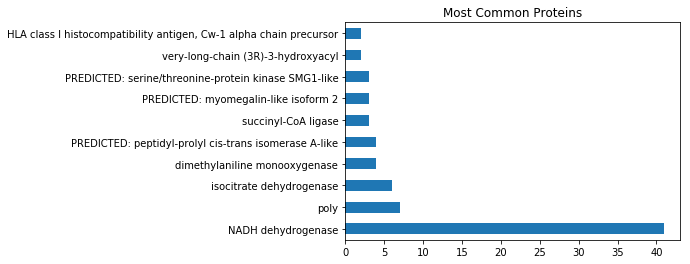

In [10]:
# Visualize the 20 most common proteins 
print("Top 10 most common proteins screened:\n", expression['gene_name'].value_counts().nlargest(10))

# Plot results -- top 10
expression['gene_name'].value_counts().nlargest(10).plot.barh(title = "Most Common Proteins")

## Data Exploration: Clinical Data

In [11]:
clinical.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [12]:
clinical.describe()

,Age at Initial Pathologic Diagnosis,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
count,105.000000,105.000000,11.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,58.685714,788.390476,1254.454545,0.104762,817.647619,-4.885714,-7.180952,4.000000,3.342857,2.590476,2.742857,1.980952,2.352381
std,13.066630,645.283040,678.050642,0.307715,672.026613,3.558074,5.022605,1.593255,1.406226,1.342323,1.074428,0.970537,1.091761
min,30.000000,0.000000,160.000000,0.000000,0.000000,-12.000000,-13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,49.000000,240.000000,947.500000,0.000000,240.000000,-6.000000,-12.000000,3.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,58.000000,643.000000,1364.000000,0.000000,665.000000,-5.000000,-6.000000,4.000000,4.000000,3.000000,3.000000,2.000000,2.000000
75%,67.000000,1288.000000,1627.500000,0.000000,1305.000000,-3.000000,-2.000000,5.000000,4.000000,3.000000,4.000000,3.000000,3.000000
max,88.000000,2850.000000,2483.000000,1.000000,2850.000000,0.000000,0.000000,7.000000,5.000000,5.000000,4.000000,4.000000,5.000000


In [13]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, TCGA-A2-A0T2 to TCGA-E2-A15A
Data columns (total 29 columns):
Gender                                 105 non-null object
Age at Initial Pathologic Diagnosis    105 non-null int64
ER Status                              105 non-null object
PR Status                              105 non-null object
HER2 Final Status                      105 non-null object
Tumor                                  105 non-null object
Tumor--T1 Coded                        105 non-null object
Node                                   105 non-null object
Node-Coded                             105 non-null object
Metastasis                             105 non-null object
Metastasis-Coded                       105 non-null object
AJCC Stage                             105 non-null object
Converted Stage                        105 non-null object
Survival Data Form                     105 non-null object
Vital Status                           105 non-null obj

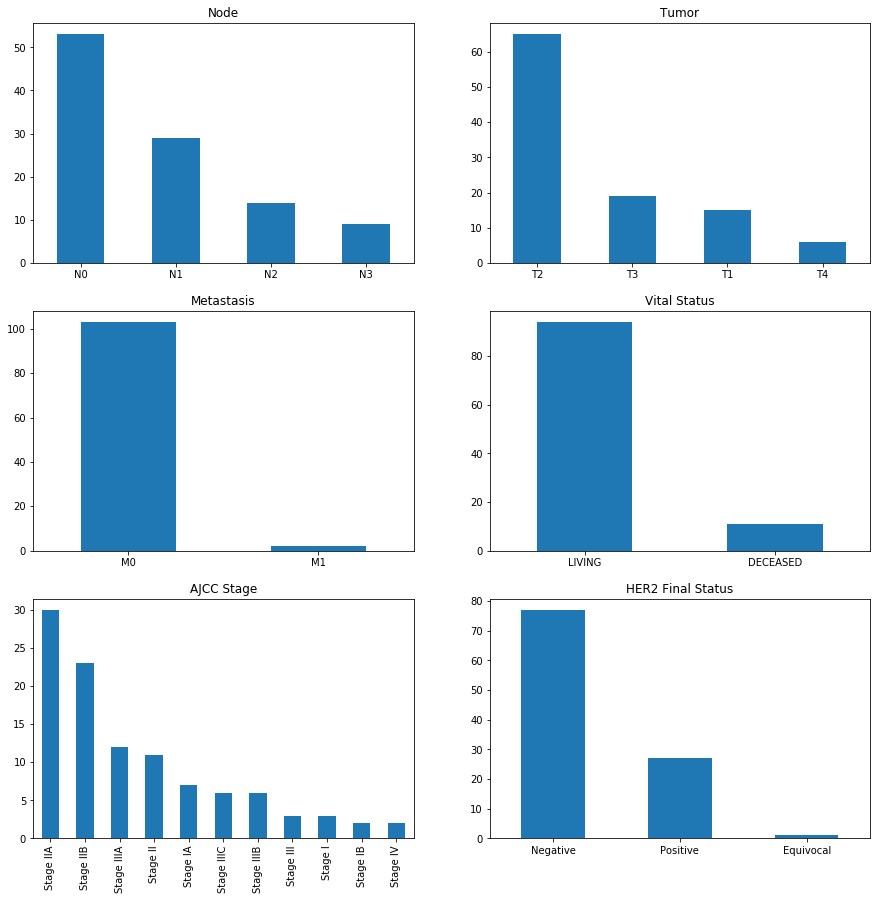

In [16]:
plt.figure(figsize = (15, 15))

plt.subplot(3, 2, 1)
clinical['Node'].value_counts().plot(kind = "bar", rot = 0, title = "Node")

plt.subplot(3, 2, 2)
clinical['Tumor'].value_counts().plot(kind = "bar", rot = 0, title = "Tumor")

plt.subplot(3, 2, 3)
clinical['Metastasis'].value_counts().plot(kind = "bar", rot = 0, title = "Metastasis")

plt.subplot(3, 2, 4)
clinical['Vital Status'].value_counts().plot(kind = "bar", rot = 0, title = "Vital Status")

plt.subplot(3, 2, 5)
clinical['AJCC Stage'].value_counts().plot(kind = "bar", title = "AJCC Stage")

plt.subplot(3, 2, 6)
clinical['HER2 Final Status'].value_counts().plot(kind = "bar", rot = 0, title = "HER2 Final Status")

plt.show()

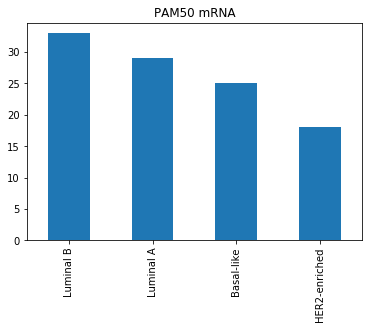

In [17]:
# This will be our target to compare against
clinical['PAM50 mRNA'].value_counts().plot.bar(title = "PAM50 mRNA")

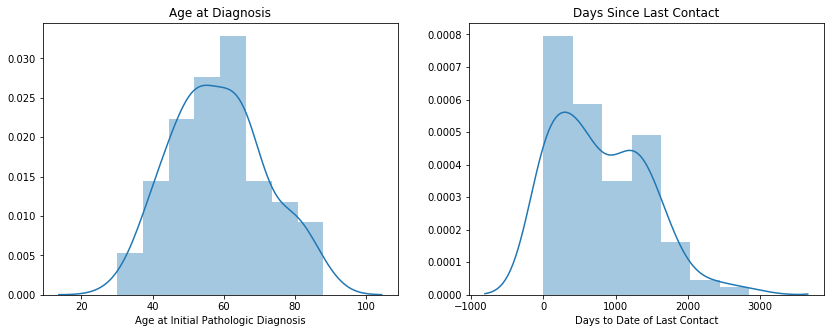

In [21]:
plt.figure(figsize = (14, 5))

plt.subplot(1, 2, 1)
sns.distplot(clinical['Age at Initial Pathologic Diagnosis'])
plt.title("Age at Diagnosis")

plt.subplot(1, 2, 2)
sns.distplot(clinical['Days to Date of Last Contact'])
plt.title("Days Since Last Contact")

plt.show()

## Data Exploration: PAM50 Protein Data

In [22]:
proteins.head()

,RefSeqProteinID,Species,Gene Name
GeneSymbol,,,
MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


In [24]:
proteins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, MIA to UBE2T
Data columns (total 3 columns):
RefSeqProteinID    100 non-null object
Species            100 non-null object
Gene Name          100 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


Top 10 most common proteins screened:
 N-acetyltransferase 1 (arylamine N-acetyltransferase)                                         9
Mdm2 p53 binding protein homolog (mouse)                                                      9
microtubule-associated protein tau                                                            6
ubiquitin-conjugating enzyme E2C                                                              6
epidermal growth factor receptor (erythroblastic leukemia viral (v-erb-b) oncogene homolog    4
estrogen receptor 1                                                                           4
fibroblast growth factor receptor 4                                                           3
exonuclease 1                                                                                 3
baculoviral IAP repeat-containing 5                                                           3
B-cell CLL/lymphoma 2                                                                         2
N

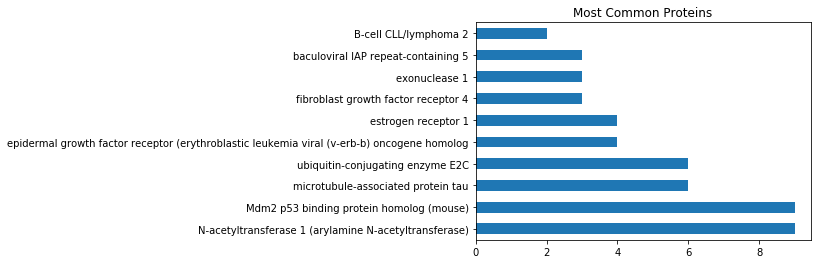

In [23]:
# Visualize the 20 most common proteins 
print("Top 10 most common proteins screened:\n", proteins['Gene Name'].value_counts().nlargest(10))

# Plot results -- top 10
proteins['Gene Name'].value_counts().nlargest(10).plot.barh(title = "Most Common Proteins")

### Setting Up Data for Unsupervised Learning:



In [25]:
## Drop unused information columns and healthy patients
expression.drop(['gene_symbol','gene_name'],axis=1,inplace=True)
  
## Change the protein data sample names to a format matching the clinical data set
expression.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
expression = expression.transpose()
 
## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in expression.index],:]
 
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = expression.merge(clinical,left_index=True,right_index=True)

## Dataframe consisting of all protein expression data
proteomes = merged.loc[:,[x for x in merged.columns if bool(re.search("NP_|XP_",x)) == True]]

## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
numerical_cols = [x for x in merged.columns if bool(re.search("NP_|XP_", x)) == True ]
processed_numerical = proteomes.loc[:, numerical_cols]
pam_50 = processed_numerical.columns.isin(proteins['RefSeqProteinID'])

# Dataframe consisting of only protein data from PAM50 proteins
p50 = processed_numerical.iloc[:, pam_50]

## Data Cleaning

In [39]:
# Drop columns with more than 55% of values as NaNs
limitPer = len(proteomes) * 0.55
proteomes = proteomes.dropna(thresh = limitPer, axis = 1)

In [41]:
# Drop columns with more than 55% of values as NaNs
limitPer = len(p50) * 0.55
p50 = p50.dropna(thresh = limitPer, axis = 1)

In [40]:
# Check for missing values
proteomes.isnull().sum()/proteomes.isnull().count()*100

NP_958782        0.00
NP_958785        0.00
NP_958786        0.00
NP_000436        0.00
NP_958781        0.00
NP_958780        0.00
NP_958783        0.00
NP_958784        0.00
NP_112598        0.00
NP_001611        0.00
NP_076965        0.00
NP_001367        0.00
NP_036222        0.00
NP_001138241     0.00
NP_001714        0.00
NP_002464        0.00
NP_001073936     0.00
NP_061198        0.00
NP_001074248     0.00
NP_001074419     0.00
NP_056009        0.00
NP_036355        0.00
NP_001155291     0.00
NP_002462        0.00
NP_000248        0.00
NP_036467        0.00
NP_004989        0.00
NP_001243024     0.00
NP_149043        0.00
NP_067047       20.00
                ...  
NP_060152       28.75
NP_001486       27.50
NP_057655       11.25
XP_003118572    36.25
NP_057125       31.25
NP_066009       27.50
NP_653179        2.50
NP_068741       26.25
NP_002460       18.75
NP_115956       31.25
NP_006685       23.75
NP_001092808    16.25
NP_694948       23.75
NP_000610       12.50
NP_699178 

There appears to be quite a bit of null values in the expression data frame. In this case, null values are indicative that no level of protein expression was detected. Taking this into consideration we can fill in those values with zero.

In [42]:
# Check for missing values
p50.isnull().sum()/p50.isnull().count()*100

NP_057427        0.00
NP_002408        0.00
NP_000415        0.00
NP_000413        0.00
NP_000517        0.00
NP_004439        0.00
NP_005219        0.00
NP_058519        0.00
NP_058518        0.00
NP_001116539     0.00
NP_061155        0.00
NP_001035932     0.00
NP_077006        0.00
NP_000917        0.00
NP_065178        0.00
NP_006836        0.00
NP_006614        0.00
NP_001784        3.75
NP_006092        2.50
NP_001153651     0.00
NP_001159403     0.00
NP_000116        0.00
NP_004314        0.00
NP_060601        2.50
NP_005931        0.00
NP_003003        0.00
NP_113611        6.25
NP_002002       13.75
NP_004487        0.00
NP_008950        0.00
NP_114172        7.50
NP_001062        6.25
NP_057547        7.50
NP_054895        0.00
NP_001246       11.25
NP_055606       43.75
NP_036451       22.50
NP_000624       25.00
NP_001159       18.75
dtype: float64

In [43]:
for column in proteomes:
    proteomes.loc[:, column] = proteomes.loc[:, column].fillna(proteomes.loc[:, column].mean())

In [44]:
for column in p50:
    p50.loc[:, column] = p50.loc[:, column].fillna(p50.loc[:, column].mean())

## Data Exploration: Proteomes and PAM50 Data

In [45]:
proteomes.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_848561,NP_057387,NP_062558,NP_665813,NP_001165887,NP_001010893,NP_683762,NP_699174,NP_001193600,NP_003593
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,-0.841106,-1.660300,-1.355399,-1.101926,0.180132,-2.512556,-2.222349,0.999326,-0.997995,0.319917
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,0.589821,-8.843890,0.748453,3.230994,1.561134,-0.517875,-2.586905,-0.384818,0.919136,0.319917
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-0.400998,-6.771952,1.800740,-1.077235,0.473015,1.670618,-2.401410,0.057932,-0.801685,3.802310
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-1.832304,-10.816632,0.705040,-0.504820,1.329574,-0.826889,-6.918196,-2.585666,-4.966177,-0.474013
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,-0.400998,-11.815089,1.691609,0.626081,3.713862,1.504016,-3.812370,2.629575,1.451490,0.319917


In [46]:
p50.head()

,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,...,NP_008950,NP_114172,NP_001062,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_001159
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,2.549550,2.733226,0.896468,-1.292949,3.541400,3.177722,0.025707,-1.792547,-0.545317,2.516489
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,2.376105,2.781928,6.836827,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,3.487128
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,0.545453,-0.273546,1.460128,-1.410193,0.702364,-1.402538,0.025707,-0.269519,1.934688,0.798041
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,...,-2.179579,-3.311022,0.139319,0.018893,-1.574649,-4.515280,0.025707,-0.269519,2.049328,-0.266769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,...,-3.752341,-3.317125,-2.769353,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-3.046991


In [47]:
#Create a dictionary for pam50 columns 
list1 = p50[0:]
list2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
         32, 33, 34, 35, 36, 37, 38, 39]
p50_dict = dict( zip( list1, list2))
print(p50_dict)

{'NP_057427': 1, 'NP_002408': 2, 'NP_000415': 3, 'NP_000413': 4, 'NP_000517': 5, 'NP_004439': 6, 'NP_005219': 7, 'NP_058519': 8, 'NP_058518': 9, 'NP_001116539': 10, 'NP_061155': 11, 'NP_001035932': 12, 'NP_077006': 13, 'NP_000917': 14, 'NP_065178': 15, 'NP_006836': 16, 'NP_006614': 17, 'NP_001784': 18, 'NP_006092': 19, 'NP_001153651': 20, 'NP_001159403': 21, 'NP_000116': 22, 'NP_004314': 23, 'NP_060601': 24, 'NP_005931': 25, 'NP_003003': 26, 'NP_113611': 27, 'NP_002002': 28, 'NP_004487': 29, 'NP_008950': 30, 'NP_114172': 31, 'NP_001062': 32, 'NP_057547': 33, 'NP_054895': 34, 'NP_001246': 35, 'NP_055606': 36, 'NP_036451': 37, 'NP_000624': 38, 'NP_001159': 39}


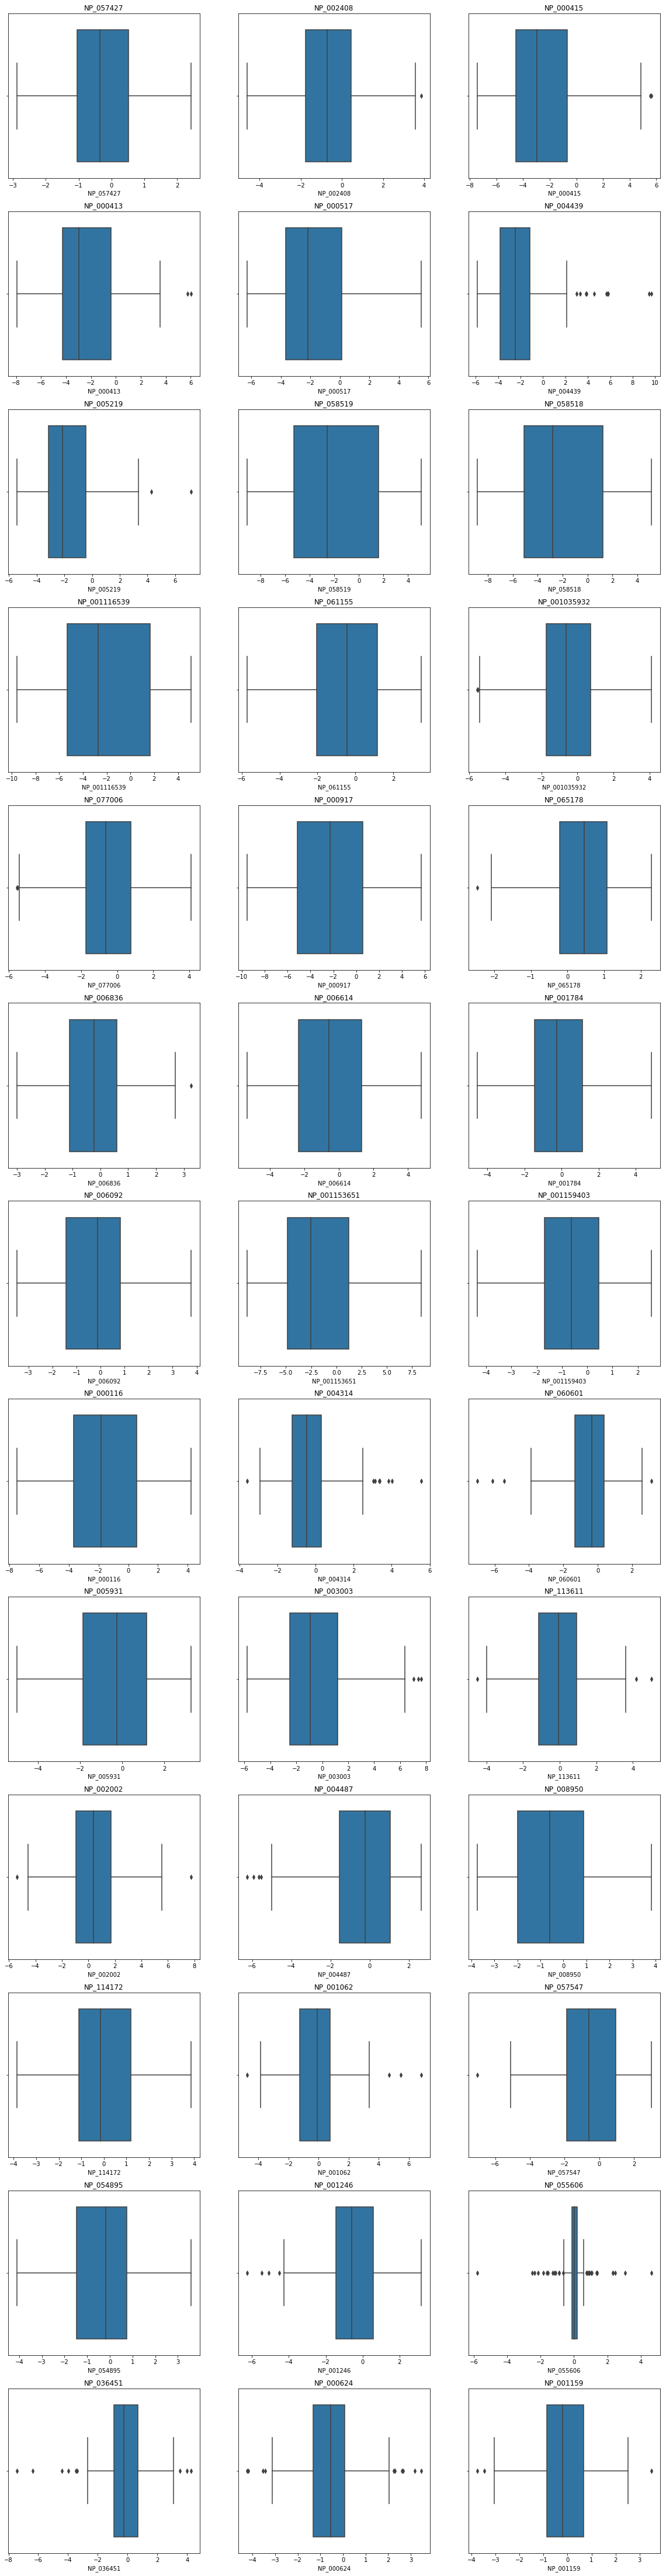

In [48]:
#visualizing the distribution of the pam50 genes
plt.figure(figsize=(20, 80))

for variable, i in p50_dict.items():
                     plt.subplot(13, 3, i)
                     sns.boxplot(p50[variable])
                     plt.title(variable)

plt.show()

We now have a a cleaned up data frame with each row representing a different patient and each column representing a different protein and its expression level. Now we can perform unsupervised learning to cluster the patients together based off their protein expression levels. But first we'll perform dimensionality reduction techniques on the data.  

### Apply dimensionality reduction techniques to visualize the observations

In [49]:
merged.replace(['Luminal B', 'Luminal A', 'Basal-like', 'HER2-enriched'],
                 [1, 2, 3, 4], inplace = True)

In [50]:
X = proteomes
y = merged['PAM50 mRNA']

# Normalize
X_std = StandardScaler().fit_transform(X)

In [51]:
X_p50 = p50

# Normalize
X_std_p50 = StandardScaler().fit_transform(X_p50)

In [52]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_p50)

plt.figure(figsize=(10,5))
colours = ["r","b","g","c"]
for i in range(pca_components.shape[0]):
    plt.text(pca_components[i, 0], pca_components[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

IndexError: 0

<Figure size 720x360 with 0 Axes>

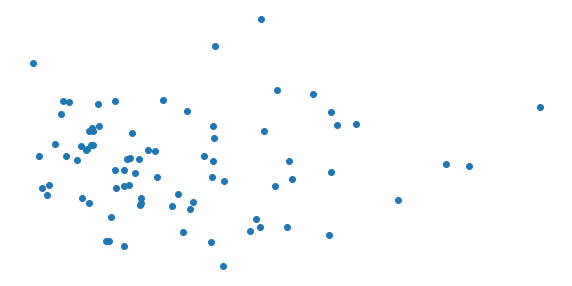

In [53]:
# visualize pca
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

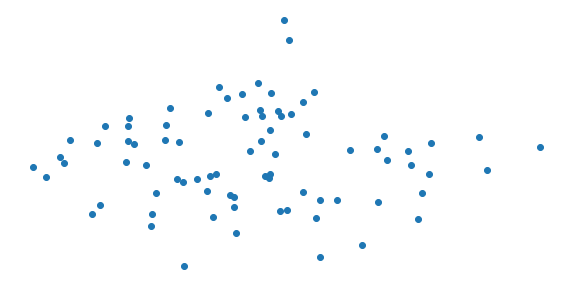

In [54]:
# visualize pca
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_std_p50)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.141s...
[t-SNE] Computed neighbors for 80 samples in 0.202s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 32.201649
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.538567
[t-SNE] KL divergence after 300 iterations: 1.762748


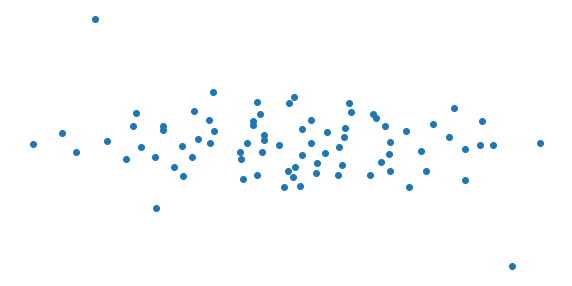

In [55]:
# visualize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.000s...
[t-SNE] Computed neighbors for 80 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 2.401752
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.939194
[t-SNE] KL divergence after 300 iterations: 1.937023


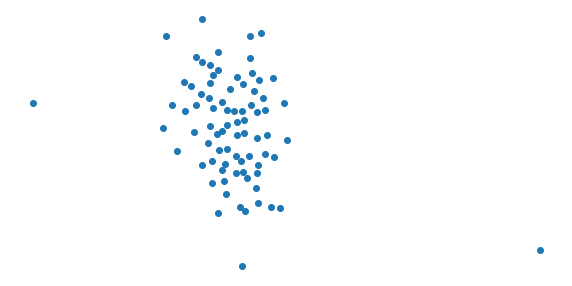

In [56]:
# visualize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X_std_p50)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

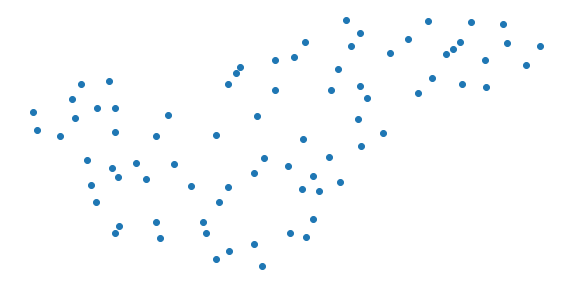

In [57]:
# visualize UMAP
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

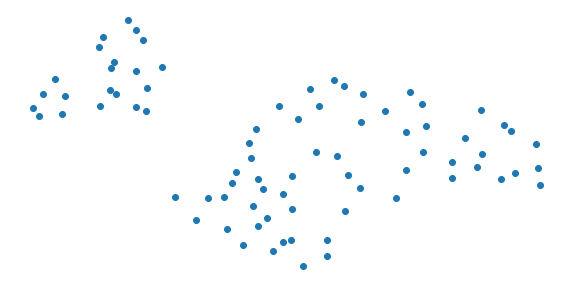

In [58]:
# visualize UMAP
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_std_p50)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Applying the dimensionality reductions using PCA, t-SNE, and UMAP they all did a really good job at separating out the patients based off their protein expression levels. UMAP and t-SNE seemed to have separated the patients more clearly than PCA and since we were only dealing with 80 rows, all these methods were very fast so speed was not an issue. It's pretty interesting that there is enough of a difference in the expression levels for all patients that we can visualize each patient as being rather distinguishable from the next. Next, we'll look at three different clustering methods and see if we can group patients together based off their proteomes.  

### Apply clustering techniques to group together similar observations.

#### K-means clustering

In [59]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2, 3, 4, 5, 6, 7, 10, 20]

In [60]:
def compare_k_means(k_list, data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k, random_state=123)
        clusterer.fit(data)
        ##
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(y, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print("\n")

In [61]:
# Evaluate k-means for the proteomes data
compare_k_means(n_clusters, proteomes)

Adjusted Rand Index for k == 2: 0.0028939413475451755
Silhouette Coefficient for k == 2: 0.12020309099125175


Adjusted Rand Index for k == 3: 0.15813588528818923
Silhouette Coefficient for k == 3: 0.05577213316124898


Adjusted Rand Index for k == 4: 0.18579790331676335
Silhouette Coefficient for k == 4: 0.051354518596864886


Adjusted Rand Index for k == 5: 0.22022049529001833
Silhouette Coefficient for k == 5: 0.04140040990724001


Adjusted Rand Index for k == 6: 0.0407200863486842
Silhouette Coefficient for k == 6: 0.04973954425908367


Adjusted Rand Index for k == 7: 0.0781548257417862
Silhouette Coefficient for k == 7: 0.047095181121979836


Adjusted Rand Index for k == 10: 0.09069754057956146
Silhouette Coefficient for k == 10: 0.04705896928127461


Adjusted Rand Index for k == 20: 0.040787470554747844
Silhouette Coefficient for k == 20: 0.047302849837309265




In [62]:
# Evaluate k-means for the PAM50 data
compare_k_means(n_clusters, p50)

Adjusted Rand Index for k == 2: 0.22133865889109447
Silhouette Coefficient for k == 2: 0.21899920135727316


Adjusted Rand Index for k == 3: 0.38346002224083564
Silhouette Coefficient for k == 3: 0.18178966873347366


Adjusted Rand Index for k == 4: 0.33286692426468145
Silhouette Coefficient for k == 4: 0.14551426096230918


Adjusted Rand Index for k == 5: 0.42020668526224336
Silhouette Coefficient for k == 5: 0.14853850428498028


Adjusted Rand Index for k == 6: 0.43028056481266963
Silhouette Coefficient for k == 6: 0.14230616774171528


Adjusted Rand Index for k == 7: 0.34279288953400827
Silhouette Coefficient for k == 7: 0.11607921088366484


Adjusted Rand Index for k == 10: 0.2081551367377609
Silhouette Coefficient for k == 10: 0.1030253025002406


Adjusted Rand Index for k == 20: 0.1642416713464822
Silhouette Coefficient for k == 20: 0.07726421653215035




The best silhouette score for k-means clustering was at 2 clusters with a score of 0.101. As we increase the number of clusters the score seems to drop, but not significantly after 3 clusters. 

#### Hierarchical clustering

In [66]:
def compare_agg_clusters_complete(k_list, data):
    print('LINKAGE: COMPLETE\n')
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = AgglomerativeClustering(linkage='complete',
                                      affinity = 'cosine',
                                      n_clusters = k)
        clusterer.fit(data)
        
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(y, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print('\n')

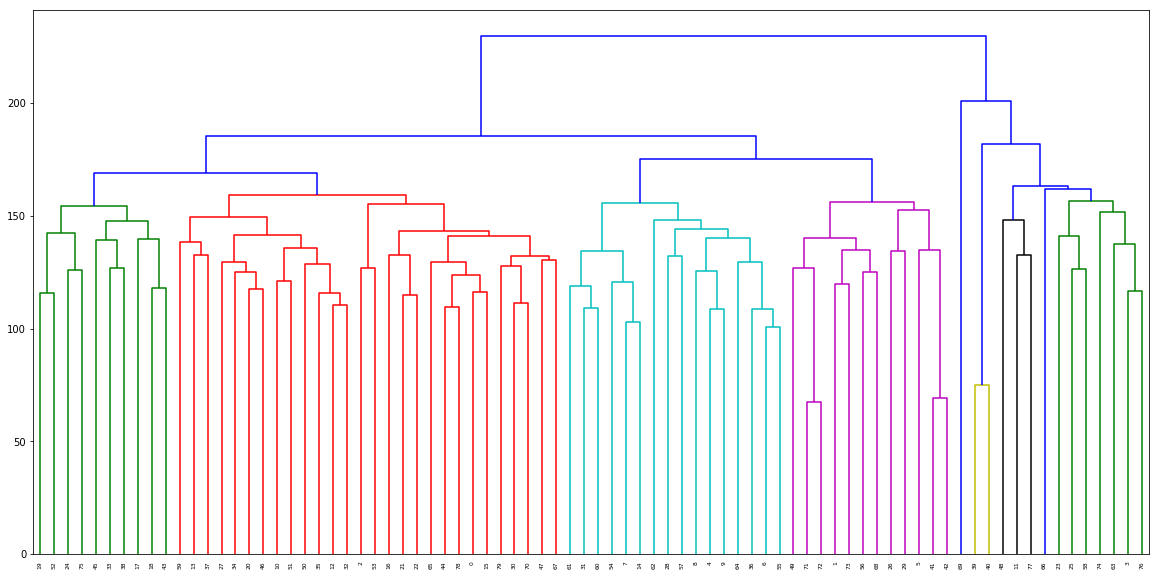

In [67]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'))
plt.show()

In [68]:
compare_agg_clusters_complete(n_clusters, proteomes)

LINKAGE: COMPLETE

Adjusted Rand Index for k == 2: 0.05868979861659757
Silhouette Coefficient for k == 2: 0.061737965933372066


Adjusted Rand Index for k == 3: 0.08187020871752192
Silhouette Coefficient for k == 3: 0.031939945081069114


Adjusted Rand Index for k == 4: 0.10696119978418131
Silhouette Coefficient for k == 4: 0.03940328423279702


Adjusted Rand Index for k == 5: 0.08069838176037238
Silhouette Coefficient for k == 5: 0.024175210028098675


Adjusted Rand Index for k == 6: 0.06504449914788864
Silhouette Coefficient for k == 6: 0.017284807255232924


Adjusted Rand Index for k == 7: 0.0970771302733593
Silhouette Coefficient for k == 7: 0.028965649970796807


Adjusted Rand Index for k == 10: 0.10651254038595741
Silhouette Coefficient for k == 10: 0.03890547058899037


Adjusted Rand Index for k == 20: 0.04739332551622051
Silhouette Coefficient for k == 20: 0.04394172054685645




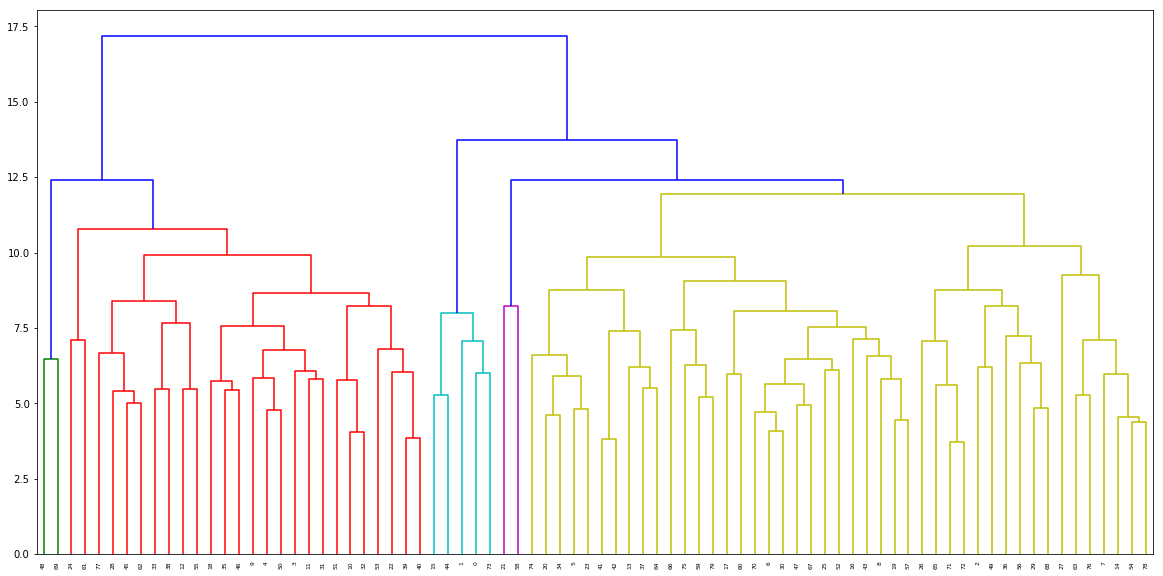

In [69]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std_p50, method='complete'))
plt.show()

In [70]:
compare_agg_clusters_complete(n_clusters, p50)

LINKAGE: COMPLETE

Adjusted Rand Index for k == 2: 0.03219715819609267
Silhouette Coefficient for k == 2: 0.17516183152009498


Adjusted Rand Index for k == 3: 0.1028089965686343
Silhouette Coefficient for k == 3: 0.10533767583261455


Adjusted Rand Index for k == 4: 0.27497341010114057
Silhouette Coefficient for k == 4: 0.10196317477037016


Adjusted Rand Index for k == 5: 0.26445682122664954
Silhouette Coefficient for k == 5: 0.09355871531644935


Adjusted Rand Index for k == 6: 0.26291736097243185
Silhouette Coefficient for k == 6: 0.09133332216133225


Adjusted Rand Index for k == 7: 0.33627564683307665
Silhouette Coefficient for k == 7: 0.12144823407719496


Adjusted Rand Index for k == 10: 0.31876753311589306
Silhouette Coefficient for k == 10: 0.10505430365594033


Adjusted Rand Index for k == 20: 0.1635827622617976
Silhouette Coefficient for k == 20: 0.07825234310852706




In [71]:
def compare_agg_clusters_average(k_list, data):
    print('LINKAGE: AVERAGE')
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = AgglomerativeClustering(linkage='average',
                                      affinity = 'cosine',
                                      n_clusters = k)
        clusterer.fit(data)
        
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(y, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print('\n')

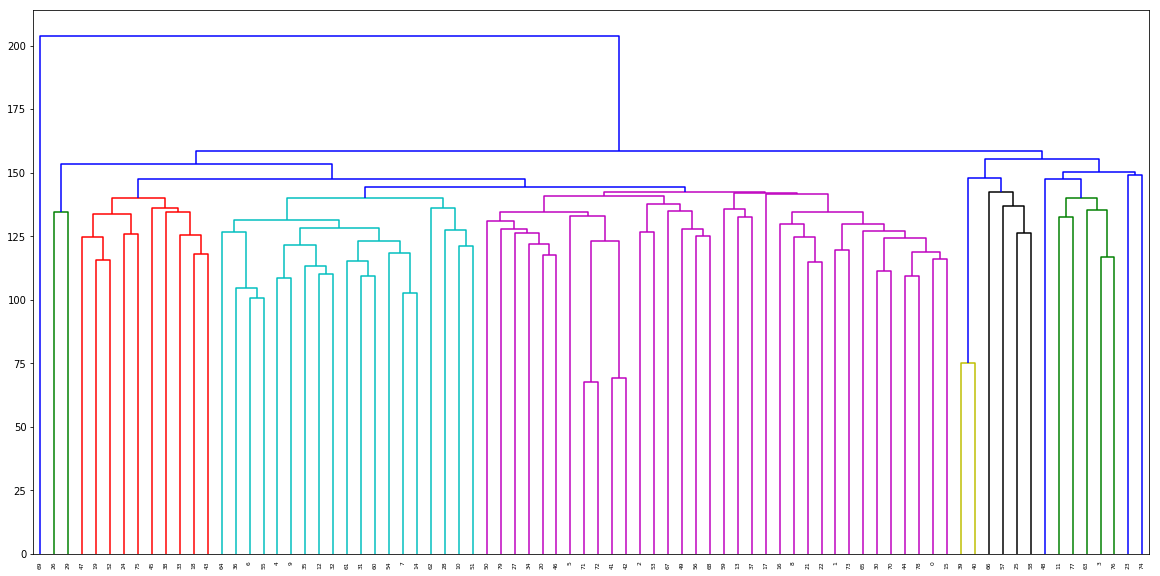

In [72]:
# Average linkage method
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='average'))
plt.show()

In [73]:
compare_agg_clusters_average(n_clusters, proteomes)

LINKAGE: AVERAGE
Adjusted Rand Index for k == 2: 0.01915894171838923
Silhouette Coefficient for k == 2: 0.04837508642546877


Adjusted Rand Index for k == 3: 0.010140585388338341
Silhouette Coefficient for k == 3: 0.022448310119022038


Adjusted Rand Index for k == 4: 0.0031439142802147445
Silhouette Coefficient for k == 4: -0.002776437717660249


Adjusted Rand Index for k == 5: -0.0025492772080011926
Silhouette Coefficient for k == 5: -0.0012576412362738294


Adjusted Rand Index for k == 6: 0.03159805657486729
Silhouette Coefficient for k == 6: 0.017840571176497014


Adjusted Rand Index for k == 7: 0.0555509952369226
Silhouette Coefficient for k == 7: 0.02005377771559746


Adjusted Rand Index for k == 10: 0.05928661956768113
Silhouette Coefficient for k == 10: 0.02194638780767904


Adjusted Rand Index for k == 20: 0.04245718686402215
Silhouette Coefficient for k == 20: 0.04881662105056049




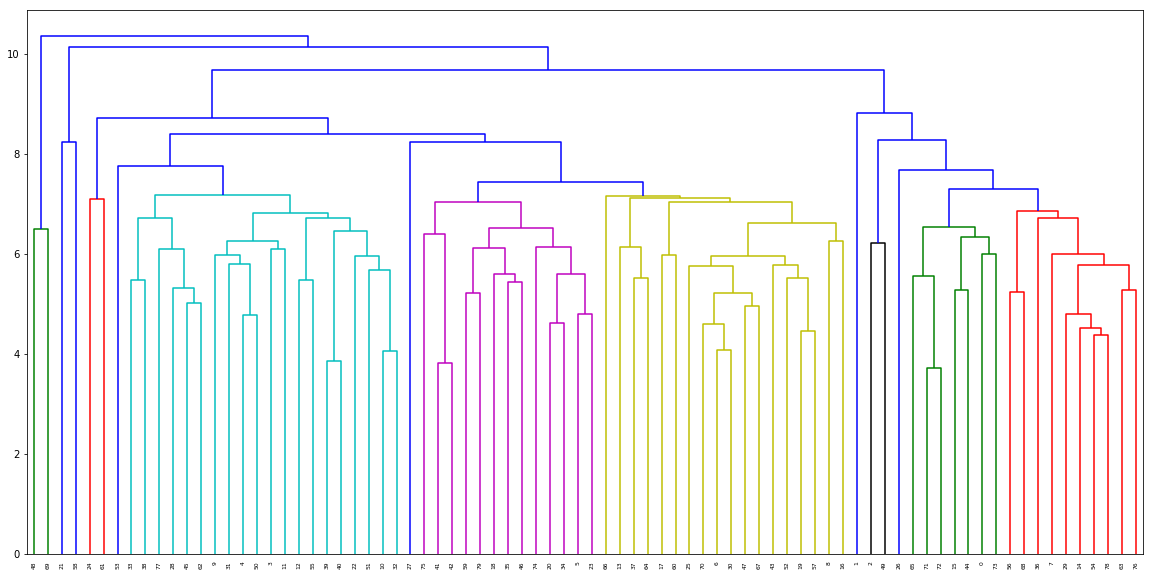

In [74]:
# Average linkage method
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std_p50, method='average'))
plt.show()

In [75]:
compare_agg_clusters_average(n_clusters, p50)

LINKAGE: AVERAGE
Adjusted Rand Index for k == 2: 0.07885015706333294
Silhouette Coefficient for k == 2: 0.19583469715008678


Adjusted Rand Index for k == 3: 0.06608207311644225
Silhouette Coefficient for k == 3: 0.13536141252821096


Adjusted Rand Index for k == 4: 0.12747679711944246
Silhouette Coefficient for k == 4: 0.09294424155567775


Adjusted Rand Index for k == 5: 0.12549073052354848
Silhouette Coefficient for k == 5: 0.07059139596140819


Adjusted Rand Index for k == 6: 0.14272535400860592
Silhouette Coefficient for k == 6: 0.053016516818098526


Adjusted Rand Index for k == 7: 0.12987484853038805
Silhouette Coefficient for k == 7: 0.0569431863630131


Adjusted Rand Index for k == 10: 0.12313049616528103
Silhouette Coefficient for k == 10: 0.00459811889165569


Adjusted Rand Index for k == 20: 0.3139635271748624
Silhouette Coefficient for k == 20: 0.05045346121864872




In [76]:
def compare_agg_clusters_ward(k_list, data):
    print('LINKAGE: WARD')
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = AgglomerativeClustering(linkage='ward',
                                      affinity = 'euclidean',
                                      n_clusters = k)
        clusterer.fit(data)
        
        print("Adjusted Rand Index for k == {}: {}".format(k, metrics.adjusted_rand_score(y, clusterer.labels_)))
        print("Silhouette Coefficient for k == {}: {}".format(k, metrics.silhouette_score(data, clusterer.labels_)))
        print('\n')

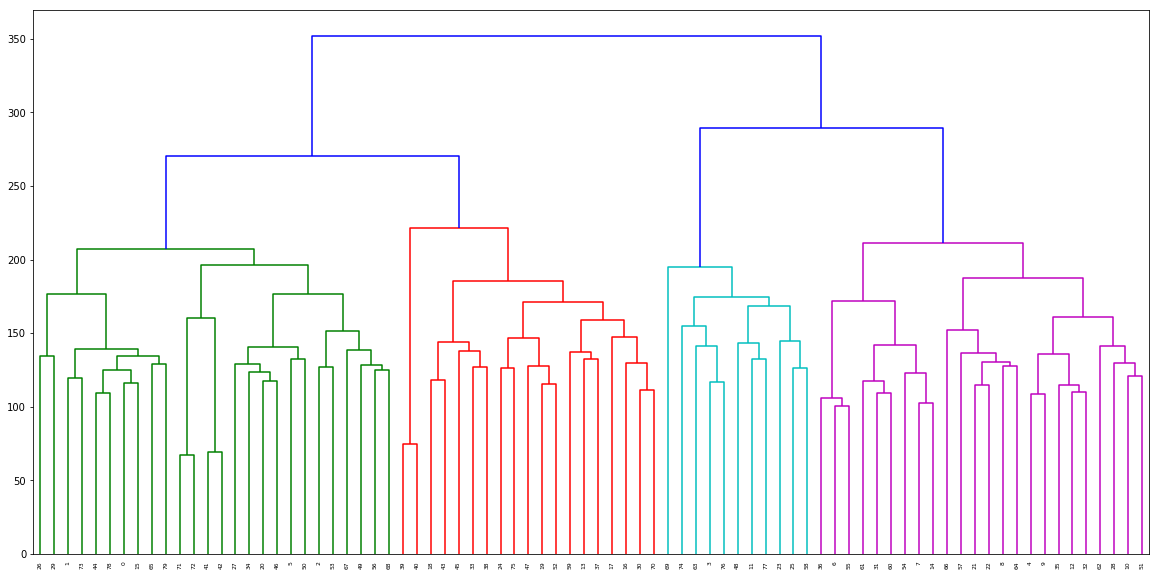

In [77]:
# Ward linkage method - proteomes
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='ward'))
plt.show()

In [78]:
# ward linkage - proteomes
compare_agg_clusters_ward(n_clusters, proteomes)

LINKAGE: WARD
Adjusted Rand Index for k == 2: -0.0020020293711987135
Silhouette Coefficient for k == 2: 0.09496279093090174


Adjusted Rand Index for k == 3: 0.13333998204846914
Silhouette Coefficient for k == 3: 0.05444332462210262


Adjusted Rand Index for k == 4: 0.15560093604029732
Silhouette Coefficient for k == 4: 0.05195001864065211


Adjusted Rand Index for k == 5: 0.13836227057422723
Silhouette Coefficient for k == 5: 0.0554571763884415


Adjusted Rand Index for k == 6: 0.17828846727145725
Silhouette Coefficient for k == 6: 0.05870429708614792


Adjusted Rand Index for k == 7: 0.1765222635967903
Silhouette Coefficient for k == 7: 0.06278284413254763


Adjusted Rand Index for k == 10: 0.15045719467062396
Silhouette Coefficient for k == 10: 0.0574520914356744


Adjusted Rand Index for k == 20: 0.09419308480703728
Silhouette Coefficient for k == 20: 0.06622026773208928




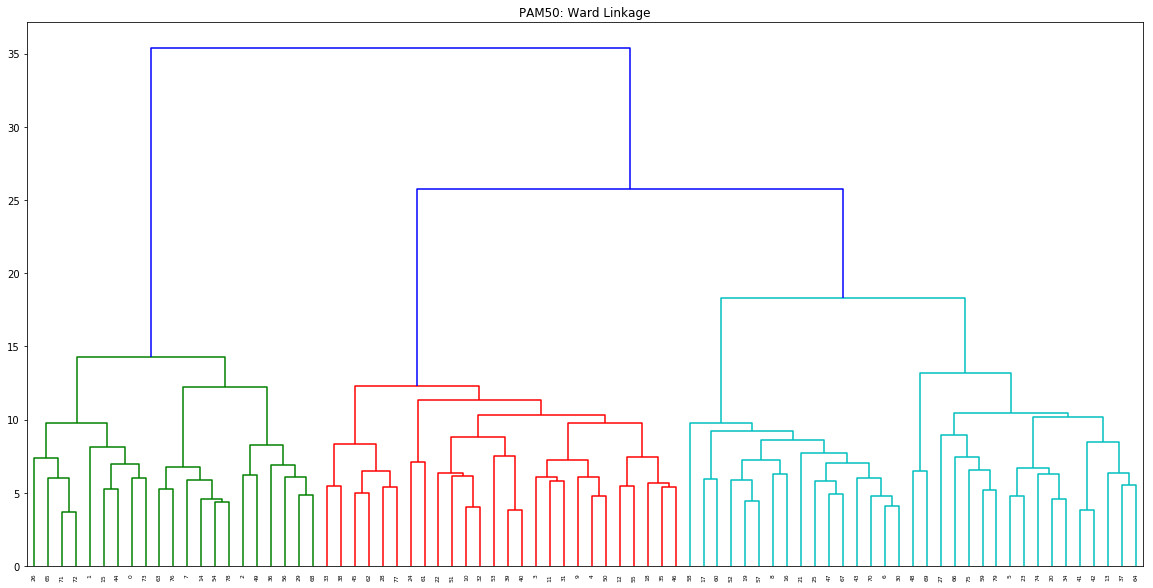

In [79]:
# Ward linkage method - PAM50
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std_p50, method='ward'))
plt.title('PAM50: Ward Linkage')
plt.show()

In [80]:
# ward linkage - PAM50
compare_agg_clusters_ward(n_clusters, p50)

LINKAGE: WARD
Adjusted Rand Index for k == 2: 0.29351548824111423
Silhouette Coefficient for k == 2: 0.209627923936194


Adjusted Rand Index for k == 3: 0.2994298333358982
Silhouette Coefficient for k == 3: 0.15717082840634647


Adjusted Rand Index for k == 4: 0.3643807858179961
Silhouette Coefficient for k == 4: 0.1415726748905616


Adjusted Rand Index for k == 5: 0.326797538913776
Silhouette Coefficient for k == 5: 0.12423863752577073


Adjusted Rand Index for k == 6: 0.32143635501198675
Silhouette Coefficient for k == 6: 0.11672480151390725


Adjusted Rand Index for k == 7: 0.28562077559372
Silhouette Coefficient for k == 7: 0.10563872765212881


Adjusted Rand Index for k == 10: 0.2175966152635346
Silhouette Coefficient for k == 10: 0.10304396717279203


Adjusted Rand Index for k == 20: 0.1283619185329071
Silhouette Coefficient for k == 20: 0.11633194077807932




Looking at the dendrograms, the ward method seemed to do the best job of grouping the patients together and there seems to be four good clusters there. 

#### GMM clustering

In [81]:
# diag covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'diag', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'diag', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'diag', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std)

gmm_cluster5 = GaussianMixture(n_components=5, covariance_type = 'diag', random_state=123)
clusters5 = gmm_cluster5.fit_predict(X_std)

# Fit model
print("Adjusted Rand Index for k == 2: {}".format(metrics.adjusted_rand_score(y, clusters2)))
print("Silhoutte Coeffiecient for k == 2: {}".format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 3: {}".format(metrics.adjusted_rand_score(y, clusters3)))
print("Silhoutte Coeffiecient for k == 3: {}".format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 4: {}".format(metrics.adjusted_rand_score(y, clusters4)))
print("Silhoutte Coeffiecient for k == 4: {}".format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 5: {}".format(metrics.adjusted_rand_score(y, clusters5)))
print("Silhoutte Coeffiecient for k == 5: {}".format(metrics.silhouette_score(X_std, clusters5, metric='euclidean')))

Adjusted Rand Index for k == 2: 0.00854030663787393
Silhoutte Coeffiecient for k == 2: 0.09656537766313626


Adjusted Rand Index for k == 3: 0.05178058406633451
Silhoutte Coeffiecient for k == 3: 0.057265403988267426


Adjusted Rand Index for k == 4: 0.13079127917977756
Silhoutte Coeffiecient for k == 4: 0.03935067007594327


Adjusted Rand Index for k == 5: 0.08437051583390726
Silhoutte Coeffiecient for k == 5: 0.024659520907641515


In [82]:
# diag covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'diag', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std_p50)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'diag', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std_p50)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'diag', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std_p50)

gmm_cluster5 = GaussianMixture(n_components=5, covariance_type = 'diag', random_state=123)
clusters5 = gmm_cluster5.fit_predict(X_std_p50)

# Fit model
print("Adjusted Rand Index for k == 2: {}".format(metrics.adjusted_rand_score(y, clusters2)))
print("Silhoutte Coeffiecient for k == 2: {}".format(metrics.silhouette_score(X_std_p50, clusters2, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 3: {}".format(metrics.adjusted_rand_score(y, clusters3)))
print("Silhoutte Coeffiecient for k == 3: {}".format(metrics.silhouette_score(X_std_p50, clusters3, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 4: {}".format(metrics.adjusted_rand_score(y, clusters4)))
print("Silhoutte Coeffiecient for k == 4: {}".format(metrics.silhouette_score(X_std_p50, clusters4, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 5: {}".format(metrics.adjusted_rand_score(y, clusters5)))
print("Silhoutte Coeffiecient for k == 5: {}".format(metrics.silhouette_score(X_std_p50, clusters5, metric='euclidean')))

Adjusted Rand Index for k == 2: 0.19773407644844881
Silhoutte Coeffiecient for k == 2: 0.16155052888751248


Adjusted Rand Index for k == 3: 0.4126641974100625
Silhoutte Coeffiecient for k == 3: 0.14398424457869693


Adjusted Rand Index for k == 4: 0.49883940767464535
Silhoutte Coeffiecient for k == 4: 0.11691297270622954


Adjusted Rand Index for k == 5: 0.3095756287557166
Silhoutte Coeffiecient for k == 5: 0.09418865737897225


In [83]:
# spherical covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'spherical', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'spherical', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'spherical', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std)

gmm_cluster5 = GaussianMixture(n_components=5, covariance_type = 'spherical', random_state=123)
clusters5 = gmm_cluster5.fit_predict(X_std)

# Fit model
print("Adjusted Rand Index for k == 2: {}".format(metrics.adjusted_rand_score(y, clusters2)))
print("Silhoutte Coeffiecient for k == 2: {}".format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 3: {}".format(metrics.adjusted_rand_score(y, clusters3)))
print("Silhoutte Coeffiecient for k == 3: {}".format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 4: {}".format(metrics.adjusted_rand_score(y, clusters4)))
print("Silhoutte Coeffiecient for k == 4: {}".format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 5: {}".format(metrics.adjusted_rand_score(y, clusters5)))
print("Silhoutte Coeffiecient for k == 5: {}".format(metrics.silhouette_score(X_std, clusters5, metric='euclidean')))

Adjusted Rand Index for k == 2: 0.00854030663787393
Silhoutte Coeffiecient for k == 2: 0.09656537766313626


Adjusted Rand Index for k == 3: 0.04934989718955353
Silhoutte Coeffiecient for k == 3: 0.049311044714496564


Adjusted Rand Index for k == 4: 0.13079127917977756
Silhoutte Coeffiecient for k == 4: 0.03935067007594327


Adjusted Rand Index for k == 5: 0.09703205488883594
Silhoutte Coeffiecient for k == 5: 0.025986000996081837


In [84]:
# spherical covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'spherical', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std_p50)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'spherical', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std_p50)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'spherical', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std_p50)

gmm_cluster5 = GaussianMixture(n_components=5, covariance_type = 'spherical', random_state=123)
clusters5 = gmm_cluster5.fit_predict(X_std_p50)

# Fit model
print("Adjusted Rand Index for k == 2: {}".format(metrics.adjusted_rand_score(y, clusters2)))
print("Silhoutte Coeffiecient for k == 2: {}".format(metrics.silhouette_score(X_std_p50, clusters2, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 3: {}".format(metrics.adjusted_rand_score(y, clusters3)))
print("Silhoutte Coeffiecient for k == 3: {}".format(metrics.silhouette_score(X_std_p50, clusters3, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 4: {}".format(metrics.adjusted_rand_score(y, clusters4)))
print("Silhoutte Coeffiecient for k == 4: {}".format(metrics.silhouette_score(X_std_p50, clusters4, metric='euclidean')))
print("\n")

print("Adjusted Rand Index for k == 5: {}".format(metrics.adjusted_rand_score(y, clusters5)))
print("Silhoutte Coeffiecient for k == 5: {}".format(metrics.silhouette_score(X_std_p50, clusters5, metric='euclidean')))

Adjusted Rand Index for k == 2: 0.19773407644844881
Silhoutte Coeffiecient for k == 2: 0.16155052888751248


Adjusted Rand Index for k == 3: 0.42370424761574277
Silhoutte Coeffiecient for k == 3: 0.14378587891842293


Adjusted Rand Index for k == 4: 0.3823221032429121
Silhoutte Coeffiecient for k == 4: 0.10022128869859845


Adjusted Rand Index for k == 5: 0.3446123540171662
Silhoutte Coeffiecient for k == 5: 0.10190398630004557


Again the best silhouette score occurs with two clusters and this was a very similar score to the other methods used. 

### Discussion

Applying the three different unsupervised clustering methods to the data, it appears that two clusters was achieving the best outcome. Without a target variable, I had to rely solely on the silhouette scores and for all three clustering methods we got very similar scores between 0.101 to 0.109. This isn't a great result, suggesting to me that there is quite a bit of difference in the protein expression patterns between the 80 patients and that there was difficulty for the algorithms grouping the clusters together. This was also evident when we got such clearly defined results while performing the dimensionality reduction techniques. The original study found an optimization at 3 clusters; however, they only observed 50 proteins known to be highly associated with breast cancer. For the sake of this assignment, I wanted to examine all of the >12,000 proteins in order to have a more robust dataset. Because we had so many features in the dataset, we got to see the power of the dimensionality reduction techniques which were able to take all of those features and separate them out in a two-dimensional visualization. Clustering algorithms are a good way to find similarities between the observations in your data, however for the reasons mentioned above it is understandable how for this data we had a difficult time getting good clusters. Perhaps if we had similar data for many more breast cancer patients we would start to get better separation. 